Técnicas de Morfologia Matemática Implementadas:
1. Esqueletonização (implementada anteriormente na Task 16)
2. Reconstrução Morfológica:
  2.1. Dilatação Geodésica - Aplicada em Imunohistoquímica
     - Ideal para reconstrução de estruturas ramificadas como vasos sanguíneos e glândulas, encontrei alguns datasets na kaggle, mas usei as imgs do scikit image mesmo.
  2.2. Reconstrução por Dilatação/Erosão - Aplicada em Moedas
     - Preserva os formatos originais dos objetos enquanto remove ruído, poderia ser usado na Lena, preservar tipo os detalhes faciais enquanto remove ruídos
  2.3. Abertura por Reconstrução - Aplicada em Coffee
     - Mantém detalhes estruturais após filtragem de ruídos e pequenos objetos, remover coisas que tocam as bordas
  2.4. Eliminação de Elementos de Borda - Aplicada em Horse
     - Remove eficientemente objetos incompletos ou que tocam as bordas

Cada técnica morfológica foi demonstrada com uma imagem apropriada para
destacar suas características e aplicabilidade em problemas específicos de processamento de imagem.

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.morphology import disk, erosion, dilation, opening, closing
from skimage.morphology import reconstruction, binary_erosion, binary_dilation
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu

In [32]:
def plot_results(images, title="Resultados"):
    """
    Visualizar múltiplas imagens
    """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))
    
    if n == 1:
        axes = [axes]
    # gray e color accept
    for i, (img_title, img) in enumerate(images):
        if img.ndim == 3 and img.shape[2] == 3:
            axes[i].imshow(img)
        else:
            axes[i].imshow(img, cmap='gray')
        axes[i].set_title(img_title)
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# 1. Horse / esqueletonização e eliminação de bordas
horse = data.horse()
horse_binary = horse > 0 

# 2. Immunohistochemistry / dilatação geodésica
ihc_image = data.immunohistochemistry()
ihc_gray = color.rgb2gray(ihc_image)

# 3. Coins / reconstrução por dilatação/erosão
coins = data.coins()
coins_gray = coins / 255.0 

# 4. Coffee / abertura por reconstrução
coffee = data.coffee()
coffee_gray = color.rgb2gray(coffee)

In [33]:
# 2.1 Dilatação Geodésica
def geodesic_dilation(marker, mask, num_iterations=1):
    """
    Aplica dilatação geodésica
    
    Parameters:
    - marker: imagem marcadora (a ser dilatada)
    - mask: imagem máscara (limite superior)
    - num_iterations: número de iterações
    """
    se = disk(1) 
    result = np.copy(marker)
    
    for _ in range(num_iterations):
        # Dilatar a imagem
        dilated = dilation(result, se)
        # Restringir à máscara
        result = np.minimum(dilated, mask)
    
    return result

# 2.2 Reconstrução por Dilatação
def reconstruction_by_dilation(marker, mask, max_iterations=1000):
    """
    Reconstrução morfológica por dilatação
    
    Parameters:
    - marker: imagem marcadora (ponto de partida)
    - mask: imagem máscara (limite superior)
    - max_iterations: número máximo de iterações
    """
    prev_result = None
    result = np.copy(marker)
    iteration = 0
    while True:
        result = geodesic_dilation(result, mask)
        
        # Verificar convergência
        if prev_result is not None and np.array_equal(result, prev_result):
            break
        
        prev_result = np.copy(result)

        iteration += 1
        if iteration >= max_iterations:
            break
    
    return result

# 2.2 Reconstrução por Erosão
def reconstruction_by_erosion(marker, mask, max_iterations=1000):
    """
    Reconstrução morfológica por erosão
    
    Parameters:
    - marker: imagem marcadora
    - mask: imagem máscara (limite inferior)
    - max_iterations: número máximo de iterações
    """
    # A reconstrução por erosão, invertemos os inputs e também o resultado
    return 1 - reconstruction_by_dilation(1 - marker, 1 - mask, max_iterations)

# 2.3 Abertura por Reconstrução
def opening_by_reconstruction(image, se_size=3):
    """
    Abertura por reconstrução
    
    Parameters:
    - image: imagem de entrada
    - se_size: tamanho do elemento estruturante
    """
    se = disk(se_size)
    eroded = erosion(image, se)
    reconstructed = reconstruction_by_dilation(eroded, image)

    return reconstructed

# 2.4 Eliminação de Elementos de Borda
def remove_border_objects(binary_image):
    """
    Remove objetos conectados à borda da imagem
    
    Parameters:
    - binary_image: imagem binária de entrada
    """
    return clear_border(binary_image)

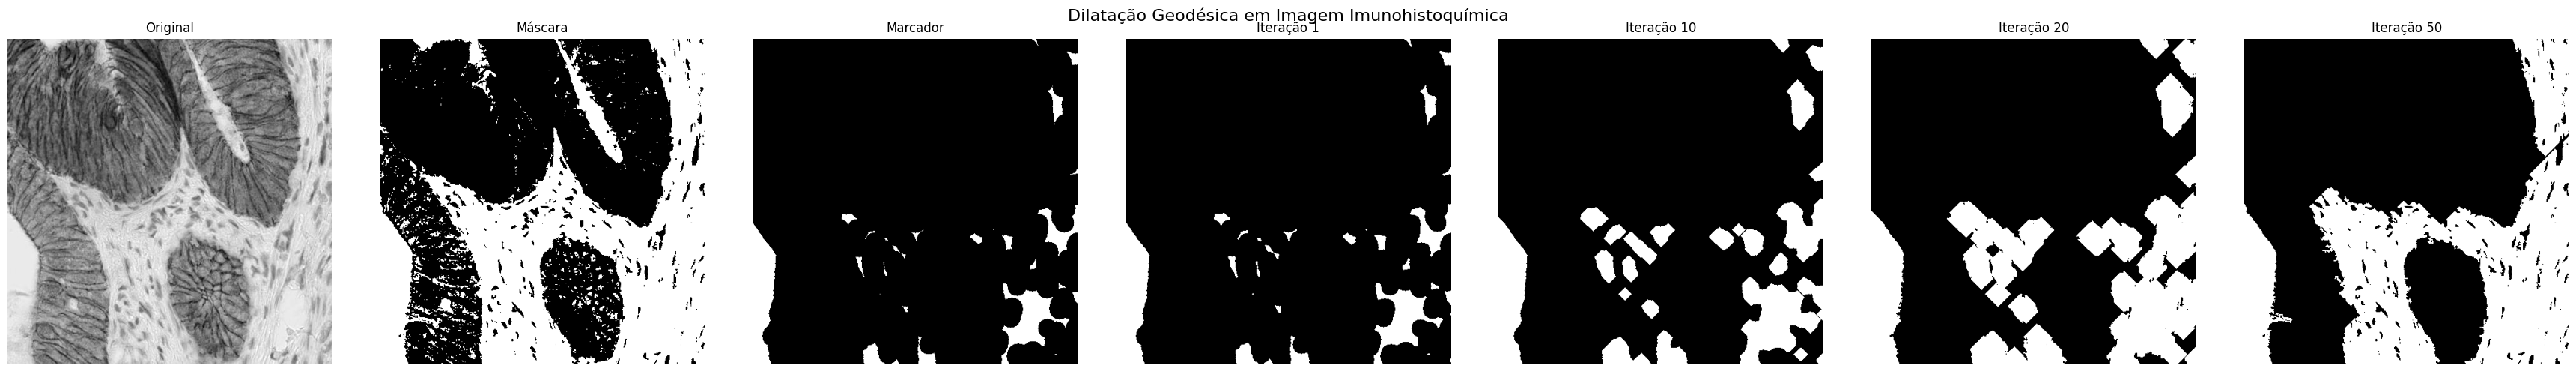

In [34]:
# Demonstração de Dilatação Geodésica usando imagem de imunohistoquímica
def demo_geodesic_dilation_ihc():
    # Limiarização para detectar estruturas interessantes
    thresh = threshold_otsu(ihc_gray)
    mask = ihc_gray > thresh
    
    # Criar marcador (pequenas áreas dentro das estruturas)
    marker = erosion(mask, disk(15))
    
    # Aplicar dilatação geodésica com diferentes números de iterações
    results = []
    iterations = [1, 10, 20, 50]
    
    for i in iterations:
        result = geodesic_dilation(marker, mask, i)
        results.append((f"Iteração {i}", result))
    
    # Visualizar
    all_images = [("Original", ihc_gray), ("Máscara", mask), ("Marcador", marker)] + results
    plot_results(all_images, "Dilatação Geodésica em Imagem Imunohistoquímica")

# Executar demonstração
demo_geodesic_dilation_ihc()

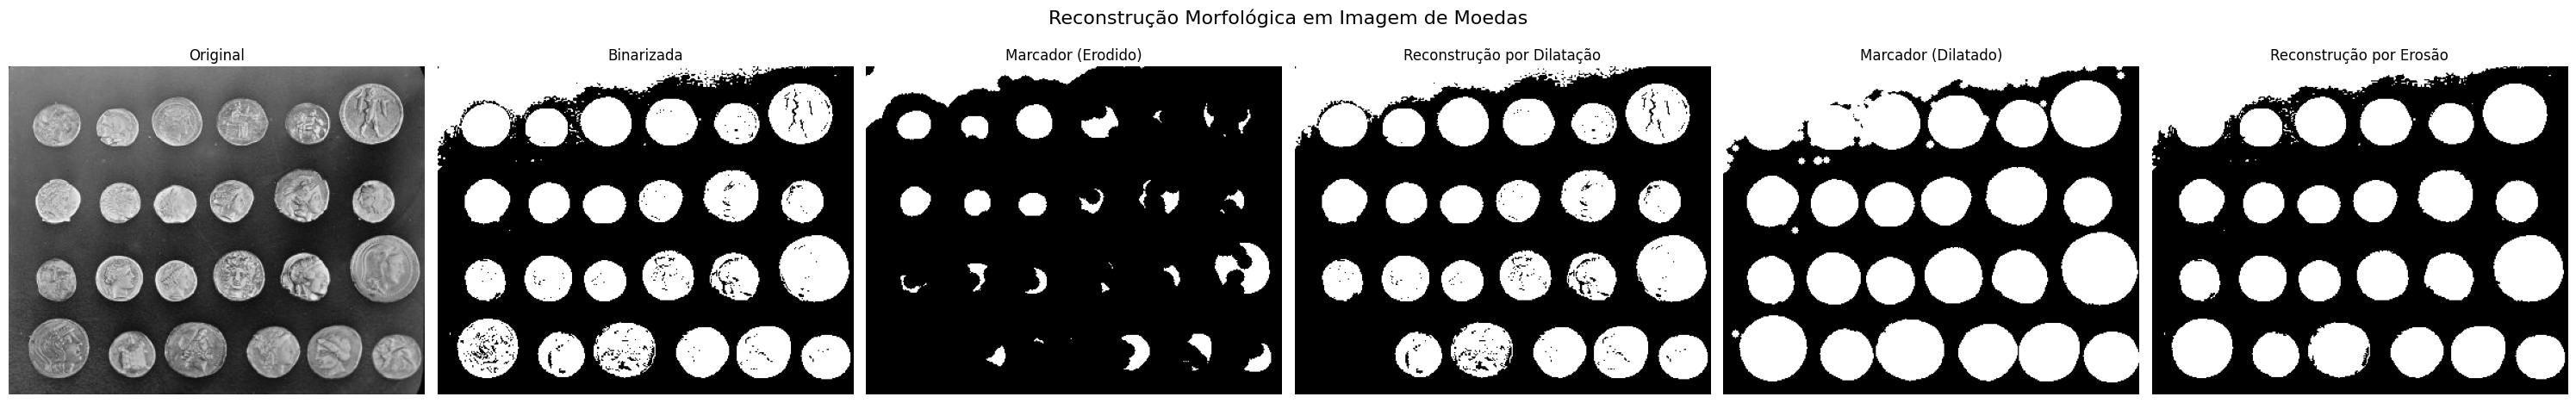

In [35]:
# Demonstração de Reconstrução por Dilatação/Erosão usando imagem de moedas
def demo_reconstruction_coins():
    # Binarização para distinguir moedas do fundo
    thresh = threshold_otsu(coins_gray)
    coins_binary = coins_gray > thresh
    
    # Criar marcador (versão erodida para reconstrução por dilatação)
    marker_dilation = erosion(coins_binary, disk(7))
    
    # Para reconstrução por erosão, criamos um marcador dilatado
    marker_erosion = dilation(coins_binary, disk(3))
    
    # Aplicar reconstrução
    rec_by_dilation = reconstruction_by_dilation(marker_dilation, coins_binary)
    rec_by_erosion = reconstruction_by_erosion(marker_erosion, coins_binary)
    
    # Visualizar
    plot_results([
        ("Original", coins_gray),
        ("Binarizada", coins_binary),
        ("Marcador (Erodido)", marker_dilation),
        ("Reconstrução por Dilatação", rec_by_dilation),
        ("Marcador (Dilatado)", marker_erosion),
        ("Reconstrução por Erosão", rec_by_erosion)
    ], "Reconstrução Morfológica em Imagem de Moedas")

# Executar demonstração
demo_reconstruction_coins()

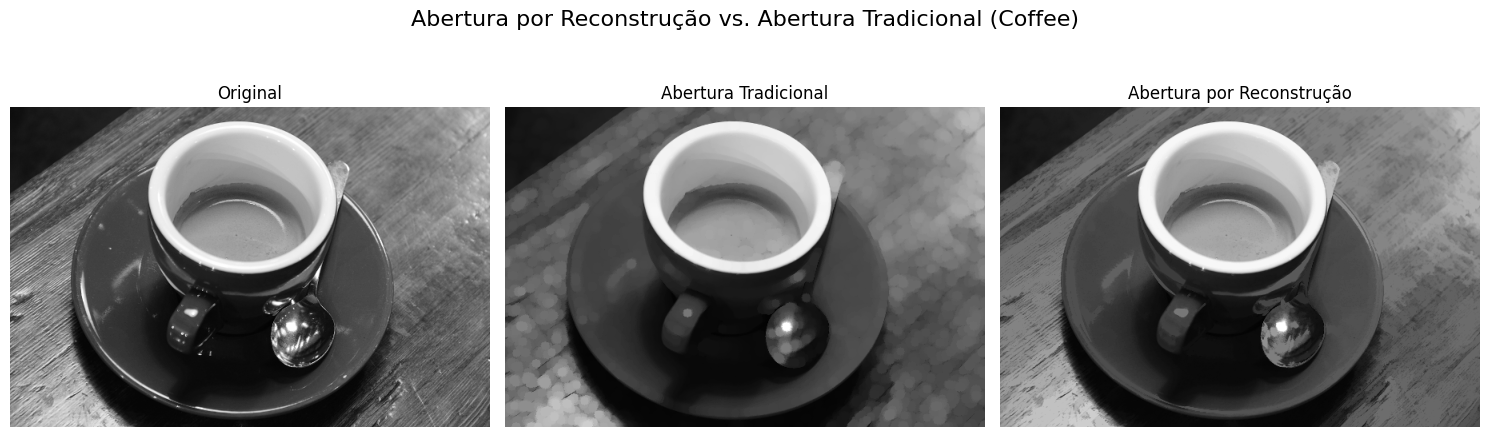

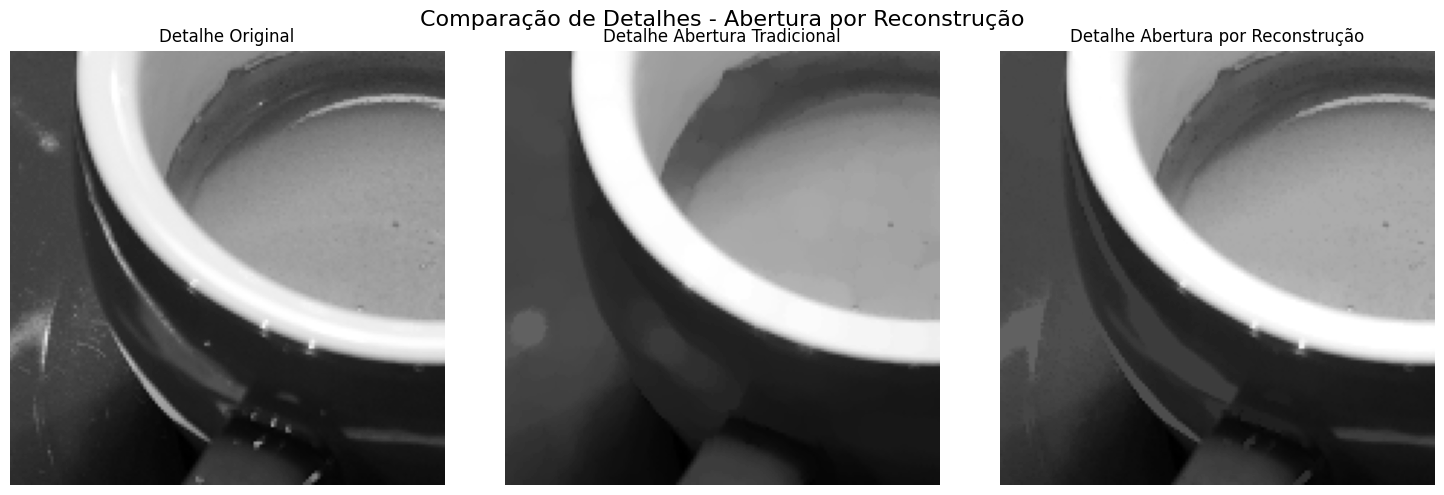

In [36]:
# Demonstração de Abertura por Reconstrução usando imagem de café
def demo_opening_by_reconstruction_coffee():
    # Aplica abertura tradicional
    se = disk(5)
    traditional_opening = opening(coffee_gray, se)
    
    # Aplica abertura por reconstrução
    rec_opening = opening_by_reconstruction(coffee_gray, 5)
    
    # Comparação de detalhes - amplia uma região específica
    # Coordenadas para região de interesse
    y1, y2 = 100, 250
    x1, x2 = 150, 300
    
    # Recorta a região para comparação detalhada
    detail_original = coffee_gray[y1:y2, x1:x2]
    detail_trad = traditional_opening[y1:y2, x1:x2]
    detail_rec = rec_opening[y1:y2, x1:x2]
    
    # Visualizar resultados completos
    plot_results([
        ("Original", coffee_gray),
        ("Abertura Tradicional", traditional_opening),
        ("Abertura por Reconstrução", rec_opening)
    ], "Abertura por Reconstrução vs. Abertura Tradicional (Coffee)")
    
    # Visualizar detalhes
    plot_results([
        ("Detalhe Original", detail_original),
        ("Detalhe Abertura Tradicional", detail_trad),
        ("Detalhe Abertura por Reconstrução", detail_rec)
    ], "Comparação de Detalhes - Abertura por Reconstrução")

# Executar demonstração
demo_opening_by_reconstruction_coffee()

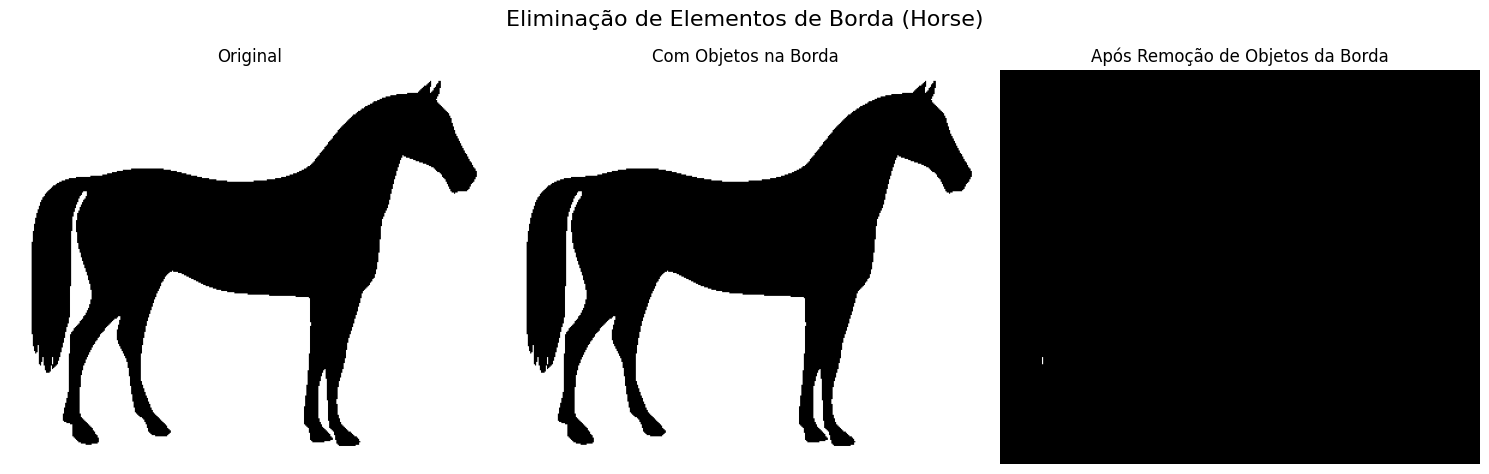

In [37]:
# Demonstração de Eliminação de Elementos de Borda usando Horse
def demo_border_clearing_horse():
    # Criar uma versão modificada com alguns objetos extras na borda
    modified = np.copy(horse_binary)
    h, w = modified.shape
    
    # Adicionar objetos nas bordas
    modified[0:30, 0:30] = True  # Objeto na borda superior esquerda
    modified[h-30:h, w-30:w] = True  # Objeto na borda inferior direita
    modified[0:20, w//2-10:w//2+10] = True  # Objeto no topo
    modified[h-20:h, w//2-10:w//2+10] = True  # Objeto na base
    
    # Remover objetos da borda
    cleared = remove_border_objects(modified)
    
    # Visualizar
    plot_results([
        ("Original", horse_binary),
        ("Com Objetos na Borda", modified),
        ("Após Remoção de Objetos da Borda", cleared)
    ], "Eliminação de Elementos de Borda (Horse)")

# Executar demonstração
demo_border_clearing_horse()